In [1]:
import numpy as np
import nibabel as nib

from utils import calculate_dice_score
from em_algo import ExpectationMaximization

## Load Data

In [2]:
# Load the two NIfTI images
T1_path = 'data/T1.nii'
T2_path = 'data/T2_FLAIR.nii'
label_path = 'data/Labels.nii'

### Load the images from the path
T1 = nib.load(T1_path)
T1_np_img = T1.get_fdata()
T2 = nib.load(T2_path)
T2_np_img = T2.get_fdata()
labels = nib.load(label_path)
labels_np_img = labels.get_fdata()

In [3]:
# Perform Skull Stripping to get the brain mask for WM, GM, and CSF
## Isolate the brain voxels using the label
#### Get the indices of the brain voxels
brain_voxels_indices = np.where(labels_np_img > 0)
#### Get the brain voxels from the T1 image using the indices get from the label
T1_skull_stripped = T1_np_img[brain_voxels_indices]
T2_skull_stripped = T2_np_img[brain_voxels_indices]

### Stack the T1 and T2 images to get the multi-modal image
X = np.vstack((T1_skull_stripped, T2_skull_stripped)).T

## EM Algorithm

Iteration:  0 Log Likelihood:  789878.3614758974


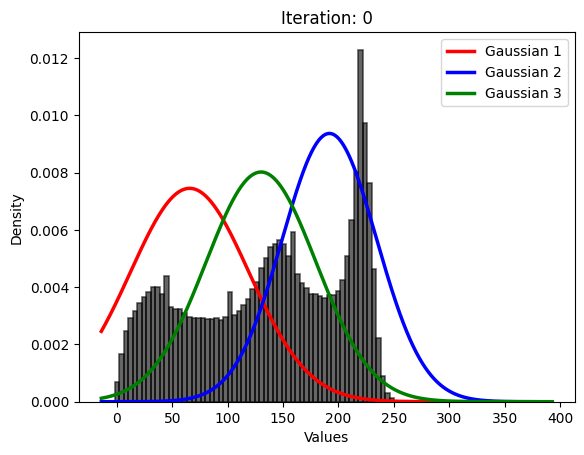

Iteration:  1 Log Likelihood:  911741.117714354
Iteration:  2 Log Likelihood:  974398.3746949525
Iteration:  3 Log Likelihood:  994582.2743414355
Iteration:  4 Log Likelihood:  1000751.2593910135
Iteration:  5 Log Likelihood:  1002799.4435953886
Iteration:  6 Log Likelihood:  1003728.5785850645
Iteration:  7 Log Likelihood:  1004468.7914770143
Iteration:  8 Log Likelihood:  1005346.1584133474
Iteration:  9 Log Likelihood:  1006515.024850385
Iteration:  10 Log Likelihood:  1008092.8810092431
Iteration:  11 Log Likelihood:  1010210.8369396923
Iteration:  12 Log Likelihood:  1012996.7928612872
Iteration:  13 Log Likelihood:  1016513.5263889114
Iteration:  14 Log Likelihood:  1020718.7274091496
Iteration:  15 Log Likelihood:  1025475.1775254679
Iteration:  16 Log Likelihood:  1030590.9442496805
Iteration:  17 Log Likelihood:  1035865.3327160629
Iteration:  18 Log Likelihood:  1041109.9721687237
Iteration:  19 Log Likelihood:  1046187.3074010009
Iteration:  20 Log Likelihood:  1051008.06747

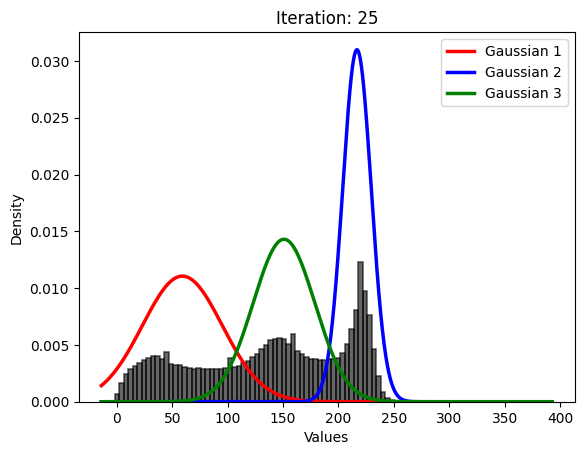

Iteration:  26 Log Likelihood:  1072899.703617523
Iteration:  27 Log Likelihood:  1075284.265329083
Iteration:  28 Log Likelihood:  1077330.0232593317
Iteration:  29 Log Likelihood:  1079063.4274533435
Iteration:  30 Log Likelihood:  1080516.305748491
Iteration:  31 Log Likelihood:  1081723.1535792125
Iteration:  32 Log Likelihood:  1082718.6801907828
Iteration:  33 Log Likelihood:  1083535.8312365506
Iteration:  34 Log Likelihood:  1084204.4806356058
Iteration:  35 Log Likelihood:  1084750.7834916844
Iteration:  36 Log Likelihood:  1085197.041464519
Iteration:  37 Log Likelihood:  1085561.9008531692
Iteration:  38 Log Likelihood:  1085860.730104664
Iteration:  39 Log Likelihood:  1086106.0674448044
Iteration:  40 Log Likelihood:  1086308.0705317047
Iteration:  41 Log Likelihood:  1086474.931135097
Iteration:  42 Log Likelihood:  1086613.2384478117
Iteration:  43 Log Likelihood:  1086728.286981404
Iteration:  44 Log Likelihood:  1086824.3316801607
Iteration:  45 Log Likelihood:  108690

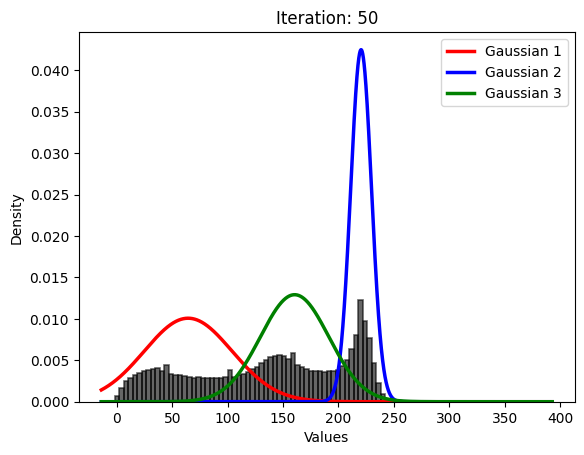

Iteration:  51 Log Likelihood:  1087183.3191297613
Iteration:  52 Log Likelihood:  1087208.741301082
Iteration:  53 Log Likelihood:  1087230.5231382793
Iteration:  54 Log Likelihood:  1087249.2214029243
Iteration:  55 Log Likelihood:  1087265.3001170617
Iteration:  56 Log Likelihood:  1087279.147512176
Iteration:  57 Log Likelihood:  1087291.0896147406
Iteration:  58 Log Likelihood:  1087301.4011760864
Iteration:  59 Log Likelihood:  1087310.314500672
Iteration:  60 Log Likelihood:  1087318.026606722
Iteration:  61 Log Likelihood:  1087324.7050601945
Iteration:  62 Log Likelihood:  1087330.49274834
Iteration:  63 Log Likelihood:  1087335.511803274
Iteration:  64 Log Likelihood:  1087339.8668418524
Iteration:  65 Log Likelihood:  1087343.6476507818
Iteration:  66 Log Likelihood:  1087346.9314239798
Iteration:  67 Log Likelihood:  1087349.7846322036
Iteration:  68 Log Likelihood:  1087352.2645923786
Iteration:  69 Log Likelihood:  1087354.420789134
Iteration:  70 Log Likelihood:  1087356

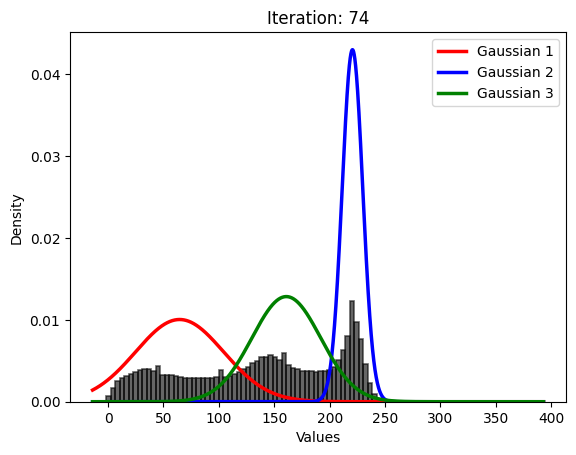

In [4]:
# Initialize the Expectation Maximization algorithm
em = ExpectationMaximization(X, k=3, max_iter=50, type='kmeans', plot_step=25, save_path='results/', show_plot=True, stop_criterion=1e-4)
alphas, mus, covars, W = em.fit()

In [7]:
mus

array([[ 64.53480908, 106.93583602],
       [220.59110845, 151.04789207],
       [160.87896821, 175.24135747]])

## Postprocessing

Sort the means of the Gaussian components. This helps us map the classes to the intensity ranges.  
	•	The smallest mean will be assigned to CSF (1).  
	•	The middle mean will be assigned to GM (2).  
	•	The largest mean will be assigned to WM (3).  

In [30]:
# Assign each voxel to the cluster with the highest probability
voxel_assignments = np.argmax(W, axis=1)  # Get the index of the highest responsibility for each voxel
# Create a new 3D image with the same shape as the original brain image
segmented_image = np.zeros_like(T1_np_img)
# Map the voxel assignments back to the 3D segmented image using the brain_voxels_indices
segmented_image[brain_voxels_indices] = voxel_assignments + 1  # +1 to make the clusters 1, 2, 3

In [31]:
## 1 - CSF, 2 - GM, 3 - WM 
## Sort the clusters based on the mean intensity of the voxels in each cluster
sorted_mean_indices = np.argsort(np.mean(mus, axis=1)) + 1
## Assign the clusters to the correct class
class1_idx = np.where(segmented_image == 1)
class2_idx = np.where(segmented_image == 2)
class3_idx = np.where(segmented_image == 3)
segmented_image[class1_idx] = sorted_mean_indices[0]
segmented_image[class2_idx] = sorted_mean_indices[1]
segmented_image[class3_idx] = sorted_mean_indices[2]

# Save the segmented image
segmented_img_nifti = nib.Nifti1Image(segmented_image, T1.affine)
nib.save(segmented_img_nifti, 'results/segmented_brain.nii')

print("Segmented brain image saved as 'results/segmented_brain.nii'")

Segmented brain image saved as 'results/segmented_brain.nii'


## Evaluation

In [32]:
# Calculate the Dice score between the predicted labels and the ground truth
dice_scores = calculate_dice_score(label_path, 'results/segmented_brain.nii')    
print(dice_scores)
print('Average Dice Score: ', np.mean(list(dice_scores.values())))

{1: 0.9066655412228951, 2: 0.8219329524136845, 3: 0.8497252226643927}
Average Dice Score:  0.8594412387669906
